In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
!pip install prophet
from prophet import Prophet

# Cargar el dataset
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/My Drive/MODELOS MONOGRAFIA/otrasinfeccionesMonografia.csv", sep=";")

# Mostrar las primeras filas del dataset para analizar su estructura
data.head()

Mounted at /content/drive


,fecha,semana,tipo,varones,mujeres,total
0,7/1/2019,1,EDA,486,527,1013
1,7/1/2019,1,IRAsinNeumo,1176,1292,2468
2,7/1/2019,1,neumonia,30,36,66
3,14/1/2019,2,EDA,585,627,1212
4,14/1/2019,2,IRAsinNeumo,1789,1963,3752


In [ ]:
# Filtrar los datos para Neumonía en mujeres y preparar el formato
data_ira_varones = data[data['tipo'] == 'IRAsinNeumo'][['fecha', 'varones']]
data_ira_varones['fecha'] = pd.to_datetime(data_ira_varones['fecha'], dayfirst=True)
data_ira_varones = data_ira_varones.sort_values(by='fecha')
data_ira_varones.set_index('fecha', inplace=True)

In [ ]:

# Preparar los datos en el formato requerido para Prophet
data_prophet_varones = data_ira_varones.reset_index()
data_prophet_varones.columns = ['ds', 'y']  # Renombrar columnas

# Dividir en entrenamiento y prueba (85% entrenamiento, 15% prueba)
train_size = int(len(data_prophet_varones) * 0.85)
train_prophet_varones = data_prophet_varones[:train_size]
test_prophet_varones = data_prophet_varones[train_size:]


In [ ]:
# Configurar y entrenar el modelo Prophet
model_prophet_varones = Prophet()
model_prophet_varones.fit(train_prophet_varones)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbrdfzqd0/77a7u672.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbrdfzqd0/xh5_4s_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47976', 'data', 'file=/tmp/tmpbrdfzqd0/77a7u672.json', 'init=/tmp/tmpbrdfzqd0/xh5_4s_g.json', 'output', 'file=/tmp/tmpbrdfzqd0/prophet_model8therip2/prophet_model-20241130161519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:15:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Crear un DataFrame con las fechas del conjunto de prueba para realizar predicciones
future = model_prophet_varones.make_future_dataframe(periods=len(test_prophet_varones), freq='W')
forecast = model_prophet_varones.predict(future)

# Extraer solo las predicciones correspondientes al conjunto de prueba
test_forecast_varones = forecast[['ds', 'yhat']].iloc[-len(test_prophet_varones):]

In [ ]:
# Calcular las métricas de evaluación
y_true = test_prophet_varones['y'].values
y_pred = test_forecast_varones['yhat'].values

mae_prophet_varones = mean_absolute_error(y_true, y_pred)
rmse_prophet_varones = np.sqrt(mean_squared_error(y_true, y_pred))
mape_prophet_varones = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convertir a porcentaje
smape_prophet_varones = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Imprimir métricas de evaluación
print(f'MAE: {mae_prophet_varones:.2f}')
print(f'RMSE: {rmse_prophet_varones:.2f}')
print(f'MAPE: {mape_prophet_varones:.2f}%')
print(f'sMAPE: {smape_prophet_varones:.2f}%')

MAE: 668.55
RMSE: 793.36
MAPE: 33.72%
sMAPE: 26.54%


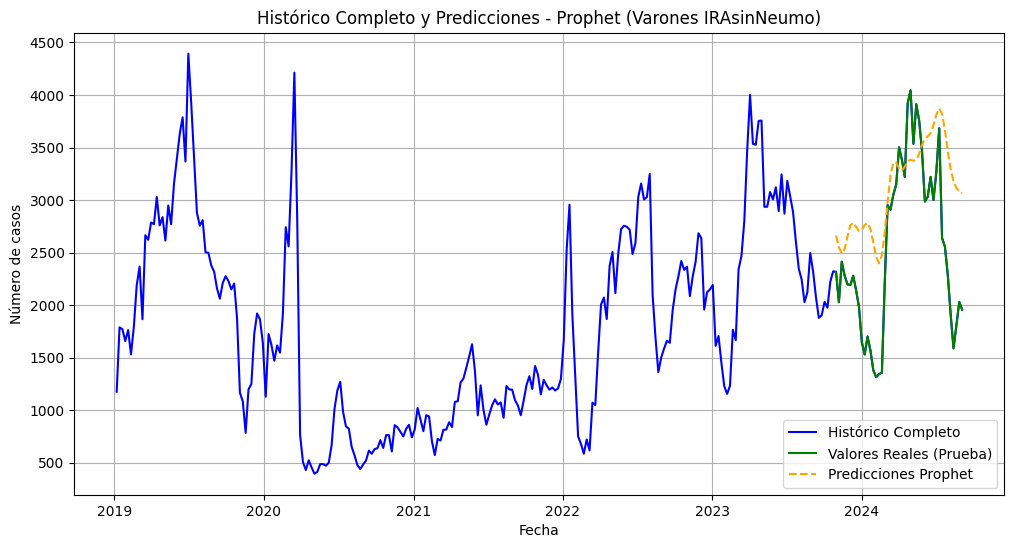

In [ ]:
# Graficar el histórico y las predicciones del modelo Prophet
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data_ira_varones.index, data_ira_varones['varones'], label="Histórico Completo", color="blue")
plt.plot(test_prophet_varones['ds'], y_true, label="Valores Reales (Prueba)", color="green")
plt.plot(test_prophet_varones['ds'], y_pred, color='orange', linestyle='--', label="Predicciones Prophet")
plt.title("Histórico Completo y Predicciones - Prophet (Varones IRAsinNeumo)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Crear DataFrame comparativo de los valores reales y predichos
comparison_df_prophet_varones = pd.DataFrame({
    'Fecha': test_prophet_varones['ds'],
    'Valores Reales': y_true,
    'Predicciones Prophet': y_pred
})

# Mostrar el DataFrame comparativo
print(comparison_df_prophet_varones)

         Fecha  Valores Reales  Predicciones Prophet
251 2023-10-30            2317           2662.853353
252 2023-11-06            2028           2552.584031
253 2023-11-13            2414           2490.784281
254 2023-11-20            2282           2535.584337
255 2023-11-27            2197           2655.289925
256 2023-12-04            2192           2759.727808
257 2023-12-11            2280           2784.463094
258 2023-12-18            2142           2744.034907
259 2023-12-25            1985           2705.789390
260 2024-01-01            1648           2717.662788
261 2024-01-08            1531           2763.353125
262 2024-01-15            1702           2781.931166
263 2024-01-22            1571           2724.769745
264 2024-01-29            1382           2597.634165
265 2024-02-05            1315           2461.373563
266 2024-02-12            1344           2399.871348
267 2024-02-19            1357           2475.927404
268 2024-02-26            2212           2692.